# Introduction to image classification using camera trap images

## 1. Set up your environment

```
pip install pandas matplotlib Pillow tqdm scikit-learn torch torchvision
```



## 2. Download the data


In [380]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [381]:
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

In [382]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [383]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


Store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [384]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 3. Explore the data

Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

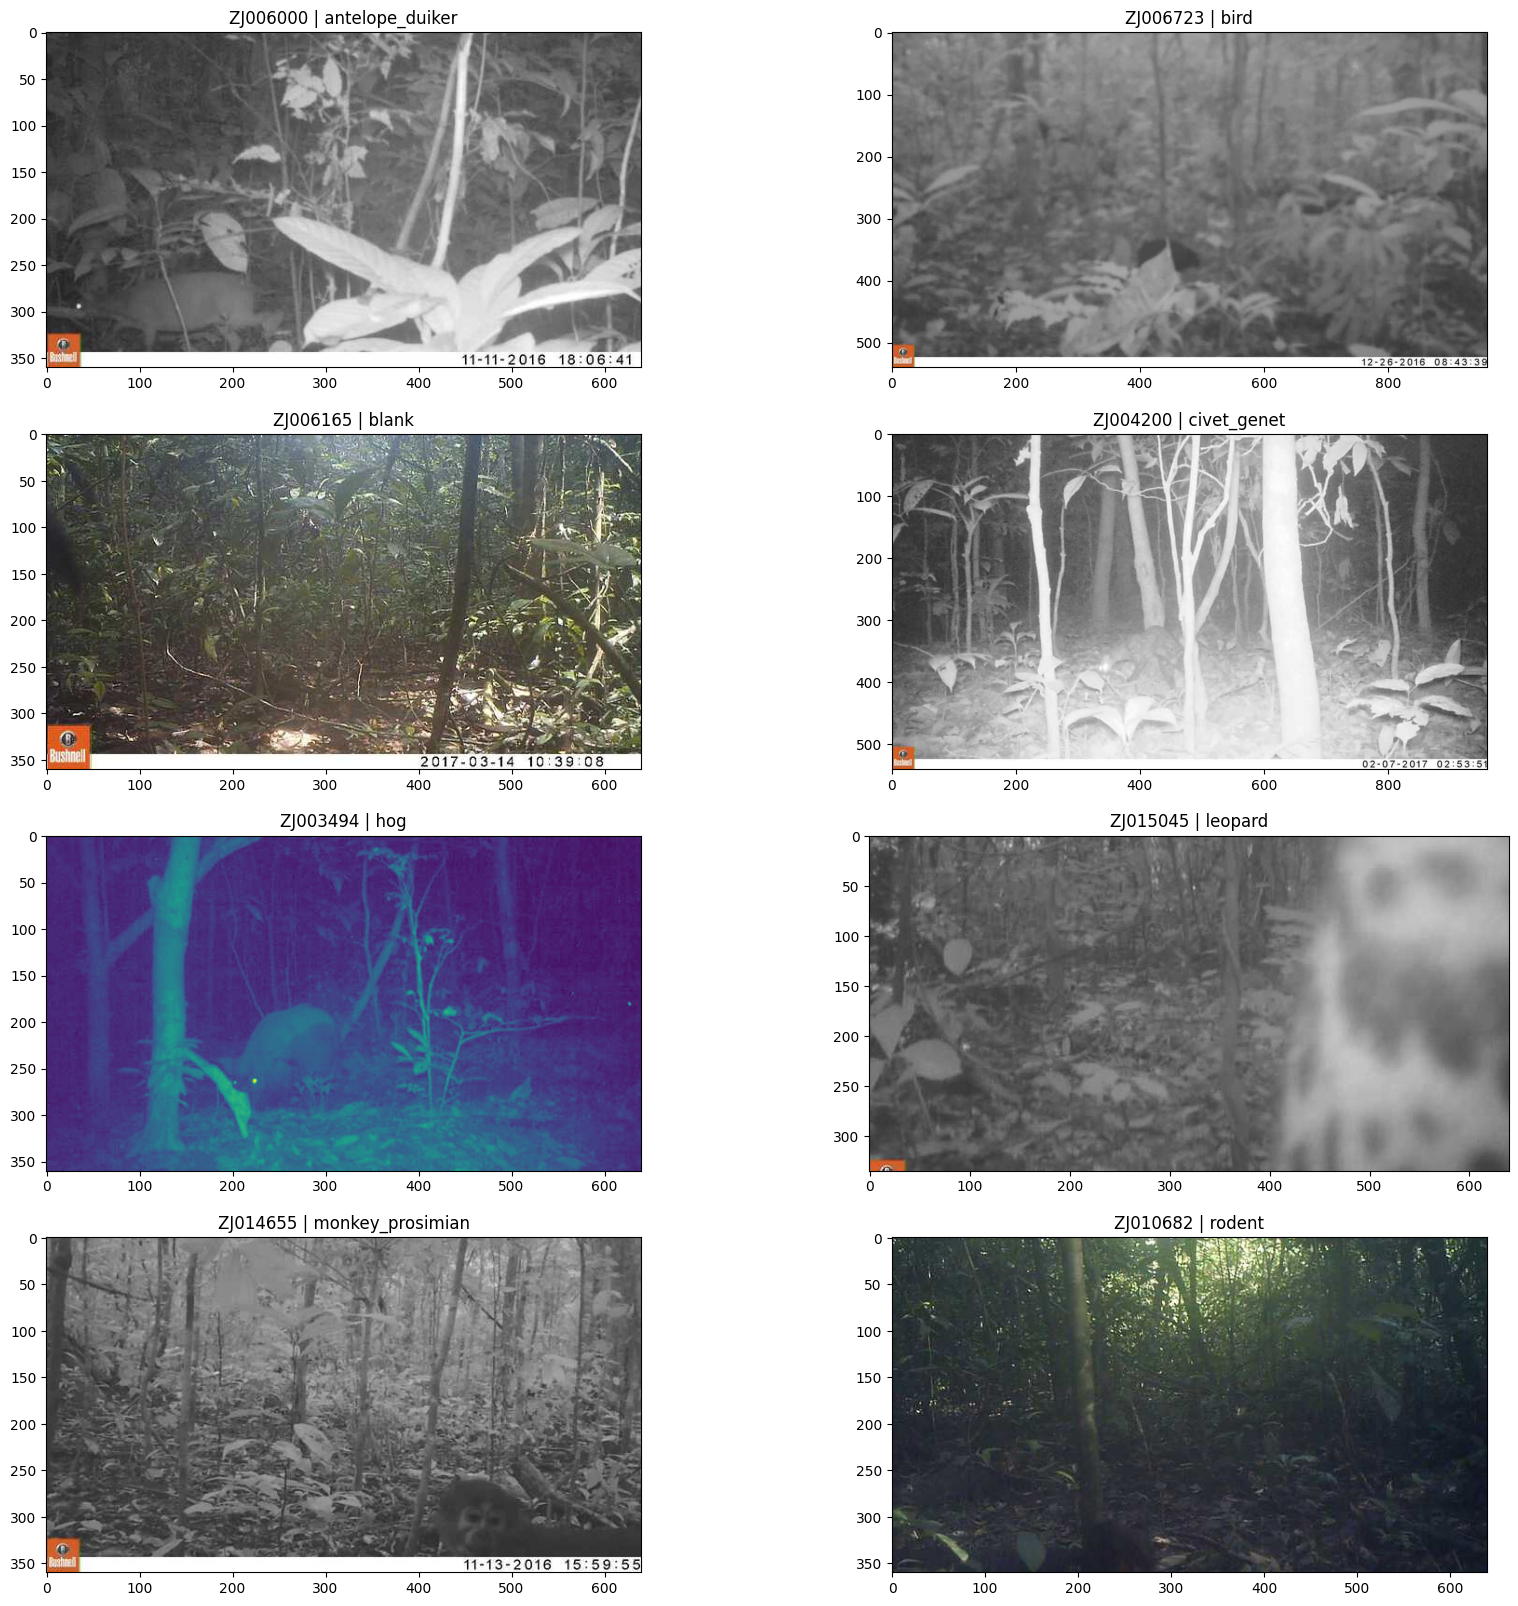

In [385]:
import matplotlib.image as mpimg

random_state = 42

# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [386]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [387]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

Dimensions histogram:

In [388]:
CALCULATE_X_Y_HISTOGRAMS = False
if CALCULATE_X_Y_HISTOGRAMS:
    import os
    from torchvision.io import read_image
    import matplotlib.pyplot as plt

    # Define paths to the image directories
    train_dir = "train_features"
    test_dir = "test_features"

    def get_images_dimensions(image_filepaths):
        """
        Returns:
            list of tuples: Each tuple contains (width, height) of an image.
        """
        dimensions = []
        for img_path in tqdm(image_filepaths):
            img = read_image(img_path)  # Read image as a tensor
            _, height, width = img.shape  # Tensor shape is (C, H, W)
            dimensions.append((width, height))
        return dimensions

    # Get image dimensions for training and test sets
    train_dimensions = get_images_dimensions(train_features["filepath"])


In [389]:
if CALCULATE_X_Y_HISTOGRAMS:
    import matplotlib.colors as mcolors
    # Separate widths and heights
    widths, heights = zip(*train_dimensions)

    # Calculate min and max of dimensions
    min_width, max_width = min(widths), max(widths)
    min_height, max_height = min(heights), max(heights)

    print("Width: Min =", min_width, "Max =", max_width)
    print("Height: Min =", min_height, "Max =", max_height)

    # Plot joint histogram of widths and heights
    plt.figure(figsize=(8, 6))
    plt.hist2d(widths, heights, bins=(40, 40), cmap='Blues', norm=mcolors.LogNorm())
    plt.title('Joint Histogram of Image Widths and Heights')
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.colorbar(label='Frequency')
    plt.tight_layout()
    plt.show()

Global mean per channel:

In [390]:
CALCULATE_GLOBAL_MEAN = False

import torch

if CALCULATE_GLOBAL_MEAN:
    from torchvision.io import read_image
    
    
    img_paths = train_features["filepath"]
    global_mean_per_channel = 0
    
    for img_path in tqdm(img_paths):
        img = read_image(img_path).float()  # Convert image to floating point dtype
        # Calculate the mean brightness for each channel (C, H, W) -> (C,)
        img_mean = img.mean(dim=(1, 2), keepdim=True)
        global_mean_per_channel += img_mean

    global_mean_per_channel = global_mean_per_channel / len(img_paths) / 255
else:
    global_mean_per_channel = torch.tensor([[[122.0993]],[[125.5976]],[[123.2581]]]) / 255

print(f"Global mean per channel: {global_mean_per_channel}")

Global mean per channel: tensor([[[0.4788]],

        [[0.4925]],

        [[0.4834]]])


## 4. Split into train and evaluation sets
First, we'll need to split the images into train and eval sets. We'll put aside 25% of the data for evaluation and stratify by the target labels to ensure we have similar relative frequencies of each class in the train and eval sets.

For the purposes of this benchmark, we're also going to limit ourselves to a 50% subset of the training data, just so that things run faster. But feel free to adjust `frac` or remove it entirely if you want to run the training on the full set.

In [391]:
from sklearn.model_selection import train_test_split

frac = 0.5

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [392]:
x_train.shape, y_train.shape, x_eval.shape, y_eval.shape

((6183, 1), (6183, 8), (2061, 1), (2061, 8))

## 5. Build the dataloader

### The Dataset

First, we'll create an `ImagesDataset` class that will define how we access our data and any transformations we might want to apply. 

This new class will inherit from the PyTorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class, but we'll also need to define our own `__init__`, `__len__` and `__getitem__` **special methods**:
* **`__init__`** will instantiate the dataset object with two dataframes: an `x_train` df containing image IDs and image file paths, and a `y_train` df containing image IDs and labels. This will run once when we first create the dataset object, e.g. with `dataset = ImagesDataset(x_train, y_train)`.
* **`__getitem__`** will define how we access a sample from the data. This method gets called whenever we use an indexing operation like `dataset[index]`. In this case, whenever accessing a particular image sample (for example, to get the first image we'd do `dataset[0]`) the following will happen:
  * look up the image filepath using the index
  * load the image with [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html)
  * apply some transformations (more on this below)
  * return a dictionary containing the image ID, the image itself as a Tensor, and a label (if it exists)
* **`__len__`** simply returns the size of the dataset, which we do by calling `len` on the input dataframe.

In [393]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class LocalBrightnessCorrection:
    """Subtracts the local brightness mean of each image to correct for heterogeneous brightness distributions."""
    def __call__(self, image):
        # Calculate the mean brightness for each channel (C, H, W) -> (C,)
        mean_per_channel = image.mean(dim=(1, 2), keepdim=True)
        std_per_channel = image.std(dim=(1, 2), keepdim=True)
        # Subtract the mean for each channel
        image = (image - mean_per_channel)/(std_per_channel*3) + global_mean_per_channel
        return image


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                LocalBrightnessCorrection(),  # Correct brightness
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, dtype=torch.float) 
            label= torch.where(label == 1)[0]  # added to FocalLoss
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

Notice that we are also defining a set of **transformations**, which are defined in the `__init__` and called in the `__getitem__` special methods. These are applied to each image before returning it. Here's what each of those transformations do and why:

* `transforms.Resize((224, 224))` ResNet50 was trained on images of size 224x224 so we resize to the same dimensions here. See [pytorch docs](https://pytorch.org/vision/stable/models.html) and the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).
* `transforms.ToTensor()` converts the image to a tensor. Since we are passing in a PIL Image at this point, PyTorch can recognize it as an RGB image and will automatically convert the input values which are in the range [0, 255] to a range of [0, 1]. See more from the [PyTorch docs](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html).
* `transforms.Normalize(...)` normalizes the image tensors using the mean and standard deviation of ImageNet images. Because this transformation was applied to images when training the ResNet model, we want to do the same here with our images. See more from the [PyTorch docs on pretrained models](https://pytorch.org/vision/stable/models.html).

### The DataLoader


In [394]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)

eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, num_workers=8)

### Analysing transformations result

tensor([2])


tensor([2])


tensor([3])


tensor([7])


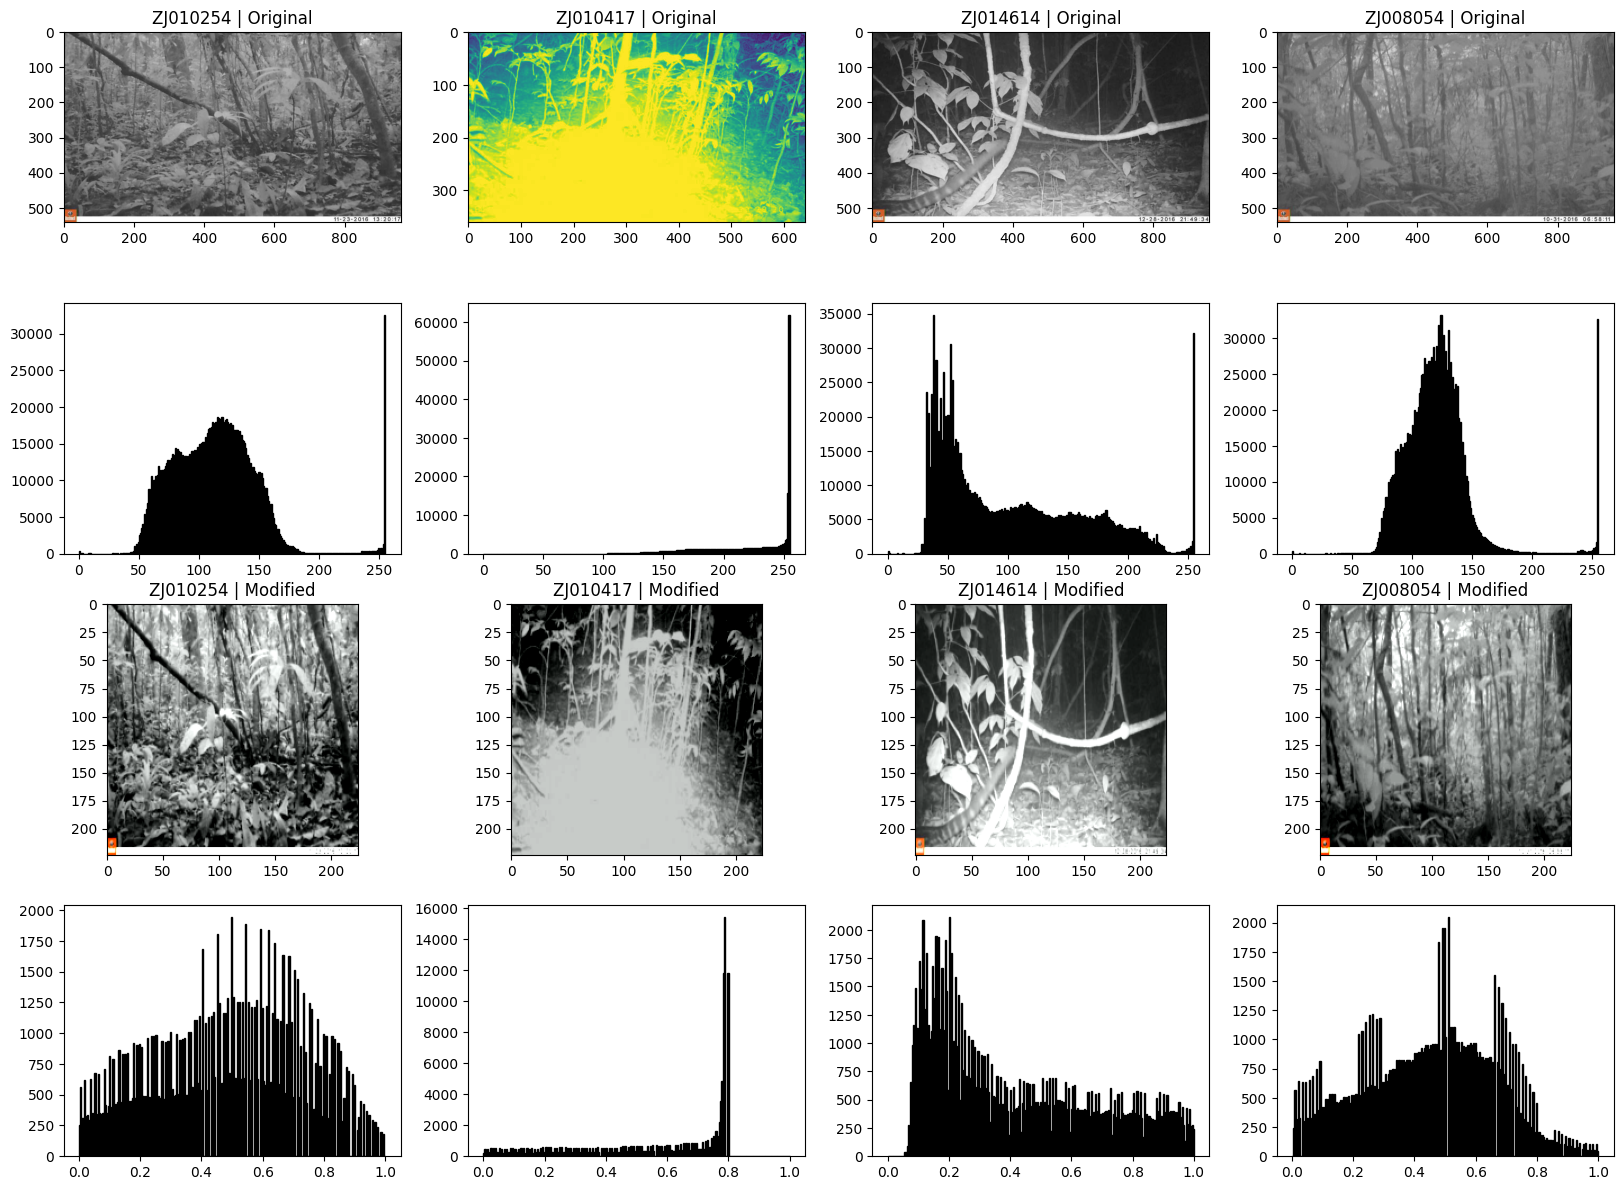

In [395]:
import matplotlib.image as mpimg
import numpy as np

random_state = 42

class Denormalize:
    """Reverses the normalization applied to an image using the given mean and std for each channel."""
    def __init__(self, mean, std):
        self.mean = np.array(mean).reshape(1, 1, 3)  
        self.std = np.array(std).reshape(1, 1, 3)  
    def __call__(self, image):
        """Reverse the normalization: p = p' * std + mean"""
        image = image * self.std + self.mean
        return image

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
for i in range(4):  
    img = train_dataset[i]["image"].permute(1, 2, 0).numpy()
    img = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img_id = train_dataset[i]["image_id"]
    label = train_dataset[i]["label"]
    print(label)
    original_img = mpimg.imread(train_features.loc[img_id].filepath)
    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"{img_id} | Original")
    axes[1, i].hist(original_img.ravel(), bins=256, range=(0.0, 255.0), fc='k', ec='k')
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"{img_id} | Modified")
    axes[3, i].hist(img.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
    

## 6. Training

### Model
Now it's time to start building our model and then training it.

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between. 

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [424]:
from torch import nn
import torchvision.models as models

MODEL_NAME = "ResNet50"
FOLDER = "saves/resnet50"
model = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)
#model = models.densenet201(weights=models.densenet.DenseNet201_Weights.DEFAULT)

# # Modify the first convolutional layer to accept grayscale input
# conv1_pretrained_weights = model.conv1.weight
# model.conv1 = nn.Conv2d(
#     in_channels=1,  # Change to 1 for grayscale
#     out_channels=64,  # Keep the original number of output channels
#     kernel_size=7,
#     stride=2,
#     padding=3,
#     bias=False
# )
# # Average the weights across the three RGB channels
# model.conv1.weight.data = conv1_pretrained_weights.mean(dim=1, keepdim=True)

model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ELU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

### Moving model to cuda

In [397]:
# Cria o modelo e move para a GPU (se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = model.to(device)

Device: cuda


### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [398]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn

#Loss function Definition
import kornia.losses as Kloss
        
weights=torch.tensor([1.0, 1, 2.0, 1, 1, 1, 1, 1]).to(device)
#criterion = Kloss.FocalLoss(alpha=1, gamma=2.0, weight=weights, reduction='mean')
criterion = nn.CrossEntropyLoss() #weight=weights

# Optimizer definition
def create_optimizer(model, lr=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    return optimizer

optimizer = create_optimizer(model) 

### Freeze pretuned parameters

In [399]:
# Freeze all pretuned parameters
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
    
optimizer = create_optimizer(model)

### Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [400]:
import playsound

num_epochs = 4
freeze_epochs = 2
VALIDATE = True

tracking_loss = {}
validation_loss = {}

# clear out the GPU memory cache
torch.cuda.empty_cache()
model.train()
playsound.playsound('notification.mp3')

for epoch in range(1, num_epochs + 1):
    print(f"--> Starting epoch {epoch}")
    
    if epoch == freeze_epochs+1:
            print("Unfreezing pretrained layers...")
            for param in model.parameters():
                param.requires_grad = True
            # Update optimizer
            optimizer = create_optimizer(model)

    # iterate through the dataloader batches. tqdm keeps track of progress.
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for batch_n, batch in pbar:
        # 0) move the data to the GPU
        batch["image"] = batch["image"].to(device)
        batch["label"] = batch["label"].to(device)
    
        # 0.2) monitor the GPU memory usage
        # allocated_memory = torch.cuda.memory_allocated(device) / 1024**2  # MB
        # reserved_memory = torch.cuda.memory_reserved(device) / 1024**2  # MB
        # max_memory = torch.cuda.max_memory_allocated(device) / 1024**2  # MB
        # pbar.set_description(f"Alocated: {allocated_memory:.2f}MB - Reserved: {reserved_memory:.2f}MB ({device}) - Max: {max_memory:.2f}MB | ")

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"].squeeze(1)) # .squeeze(1) added to FocalLoss
        pbar.set_description(f"Loss: {loss.item():.4f}")
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()
        
        # 5) clear out the GPU memory cache
        torch.cuda.empty_cache()
        
    if VALIDATE:
        ## Validation step, outside train mode, to avoid overfitting
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0  # Initialize validation loss

        with torch.no_grad():  # Disable gradient calculation
            for val_batch in eval_dataloader:
                # Move the data to the GPU
                val_batch["image"] = val_batch["image"].to(device)
                val_batch["label"] = val_batch["label"].to(device)

                # Forward pass
                val_outputs = model(val_batch["image"])
                
                # Compute validation loss
                val_loss += criterion(val_outputs, val_batch["label"].squeeze(1)).item() # .squeeze(1) added to FocalLoss

        # Store the average validation loss for this epoch
        validation_loss[(epoch, len(train_dataloader)-1)] = val_loss / len(eval_dataloader)
        print(f"Validation Loss: {validation_loss[(epoch, len(train_dataloader)-1)]:.4f}")

        # Switch back to training mode
        model.train()
        
        
playsound.playsound('notification.mp3')

        

--> Starting epoch 1


Loss: 1.7467: 100%|██████████| 194/194 [01:57<00:00,  1.66it/s]


Validation Loss: 1.6402
--> Starting epoch 2


Loss: 1.4675: 100%|██████████| 194/194 [01:47<00:00,  1.81it/s]


Validation Loss: 1.4543
--> Starting epoch 3
Unfreezing pretrained layers...


Loss: 1.1375: 100%|██████████| 194/194 [06:17<00:00,  1.95s/it]


Validation Loss: 0.6441
--> Starting epoch 4


Loss: 0.9883: 100%|██████████| 194/194 [07:30<00:00,  2.32s/it]


Validation Loss: 0.5315


Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

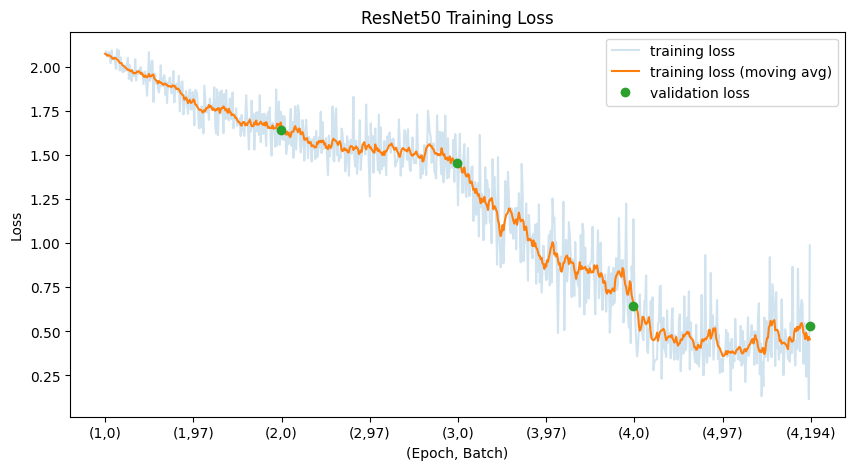

<Figure size 640x480 with 0 Axes>

In [425]:
# Choose X axis
PLOT_X = "epoch" # "time" or "epoch"

# Tracking loss
tracking_loss = pd.Series(tracking_loss)
tracking_loss.to_csv(f"{FOLDER}/tracking_loss.csv")
validation_loss = pd.Series(validation_loss)
validation_loss.to_csv(f"{FOLDER}/validation_loss.csv")

# Time to plot the loss
freeze_batches = len(train_dataloader)*freeze_epochs
time = pd.Series(list(tracking_loss.index)).apply(lambda x: (x[0]-1)*len(train_dataloader) + x[1])
time = time.apply(lambda x: x/1.46 if x <= freeze_batches  else (x-freeze_batches)*2.34 + freeze_batches/1.46)

# Plot the loss
plt.figure(figsize=(10, 5))
if PLOT_X == "epoch":
    tracking_loss.plot(alpha=0.2, label="training loss")
    tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(label="training loss (moving avg)")
    plt.plot(range(len(train_dataloader)-1, len(tracking_loss)+1, len(train_dataloader)),validation_loss, "o", label="validation loss")   
    plt.xticks(range(0, len(tracking_loss)+1, 97), [f"({epoch},{batch})" for epoch, batch in tracking_loss.index[::97]]+[f"({num_epochs},{len(train_dataloader)})"])
    plt.xlabel("(Epoch, Batch)")
if PLOT_X == "time":
    plt.plot(time, tracking_loss, alpha=0.2, label="Loss")
    plt.plot(time, tracking_loss.rolling(center=True, min_periods=1, window=10).mean(), label="Loss (Moving Avg)")
    plt.xlabel("Training Time (s)")

# plt.vlines(2*len(train_dataloader), tracking_loss.min(), tracking_loss.max(), linestyles='dashed', colors='r', label="Unfreeze Pretrained Layers")
plt.title(f"{MODEL_NAME} Training Loss")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.show()
plt.savefig(f"{FOLDER}/training_loss_{MODEL_NAME}.png")

### Save the model

In [426]:
torch.save(model, f"{FOLDER}/model-{MODEL_NAME}.pth")

## 7. Evaluation


In [403]:
#loaded_model = torch.load("model1.pth")

### Make predictions


In [404]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        
        # 0) move to cuda
        batch["image"] = batch["image"].to(device)
        batch["label"] = batch["label"].to(device)
        
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        preds = preds.cpu()
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)

  2%|▏         | 1/65 [00:02<02:13,  2.09s/it]

100%|██████████| 65/65 [00:41<00:00,  1.56it/s]


### Accuracy

In [405]:
eval_predictions = eval_preds_df.idxmax(axis=1)

In [406]:
eval_true = y_eval.idxmax(axis=1)
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.8131974769529354

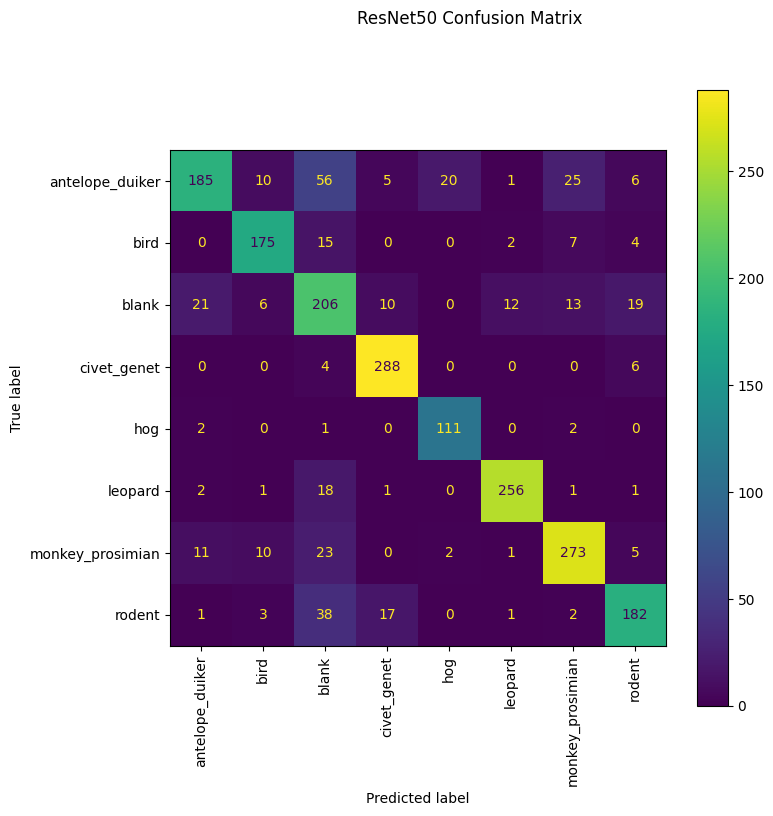

<Figure size 640x480 with 0 Axes>

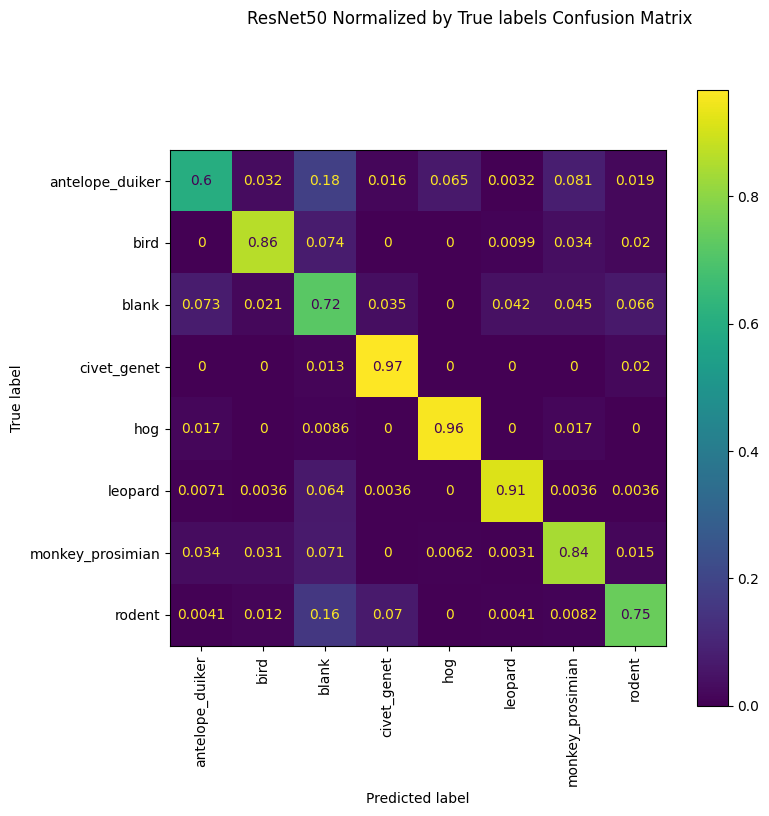

<Figure size 640x480 with 0 Axes>

In [428]:
from sklearn.metrics import ConfusionMatrixDisplay
# plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.suptitle(f"{MODEL_NAME} Confusion Matrix")
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)
plt.show()
plt.savefig(f"{FOLDER}/confusion_matrix_{MODEL_NAME}.png")

# plot normalized confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.suptitle(f"{MODEL_NAME} Normalized by True labels Confusion Matrix")
cm = ConfusionMatrixDisplay.from_predictions(
    y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    normalize='true',
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)
plt.show()
plt.savefig(f"{FOLDER}/confusion_matrix_norm_{MODEL_NAME}.png")

## 8. Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [408]:
# test_dataset = ImagesDataset(test_features.filepath.to_frame())
# test_dataloader = DataLoader(test_dataset, batch_size=32)

In [409]:
# preds_collector = []

# # put the model in eval mode so we don't update any parameters
# model.eval()

# # we aren't updating our weights so no need to calculate gradients
# with torch.no_grad():
#     for batch in tqdm(test_dataloader, total=len(test_dataloader)):
#         # run the forward step
#         logits = model.forward(batch["image"])
#         # apply softmax so that model outputs are in range [0,1]
#         preds = nn.functional.softmax(logits, dim=1)
#         # store this batch's predictions in df
#         # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
#         preds_df = pd.DataFrame(
#             preds.detach().numpy(),
#             index=batch["image_id"],
#             columns=species_labels,
#         )
#         preds_collector.append(preds_df)

# submission_df = pd.concat(preds_collector)
# submission_df

Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [410]:
# submission_format = pd.read_csv("submission_format.csv", index_col="id")

# assert all(submission_df.index == submission_format.index)
# assert all(submission_df.columns == submission_format.columns)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

In [411]:
# submission_df.to_csv("submission_df.csv")

How did we do? We should get a score of ~1.8, though your results may differ slightly due to non-determinism in model training. (For reference, a randomly generated submission yields a score of something like ~2.4.)

![benchmark submission](https://drivendata-public-assets.s3.amazonaws.com/conservision-benchmark-score.jpg)

Now it is up to you to improve on this benchmark!

Head over to the [competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) for data and more background info, or the [competition forum](https://community.drivendata.org/c/conser-vision/87) if you have any questions. Good luck!

In [412]:
playsound.playsound('notification.mp3')